In [ ]:
%load_ext autoreload
%autoreload 2

Fix shapedirs bug of MANO
mano_param None
No annotation for frame right
mano_param {'pose': [1.4361149072647095, 0.8373290300369263, -1.0623373985290527, -0.011908364482223988, 0.23524223268032074, 0.022060157731175423, -0.1532621681690216, 0.010604656301438808, 0.3380824327468872, 0.0909990444779396, 0.12150177359580994, 0.008850270882248878, -0.066767618060112, 0.050706103444099426, 0.010359534993767738, 0.06122758612036705, -0.061067789793014526, 0.3389875590801239, -0.08114345371723175, 0.04080864042043686, 0.08073431998491287, 0.07428359985351562, -0.2266584187746048, 0.29431313276290894, 0.06369622051715851, 0.07747548818588257, 0.1389223337173462, -0.02574467845261097, 0.10534118115901947, -0.11790353804826736, -0.0017547013703733683, 0.004447607323527336, 0.1082964614033699, 0.03921321779489517, -0.03784498944878578, 0.36318060755729675, -0.07147692888975143, 0.12141963839530945, 0.043621741235256195, -0.11279445886611938, -0.032219137996435165, 0.14158280193805695, -0.08972574

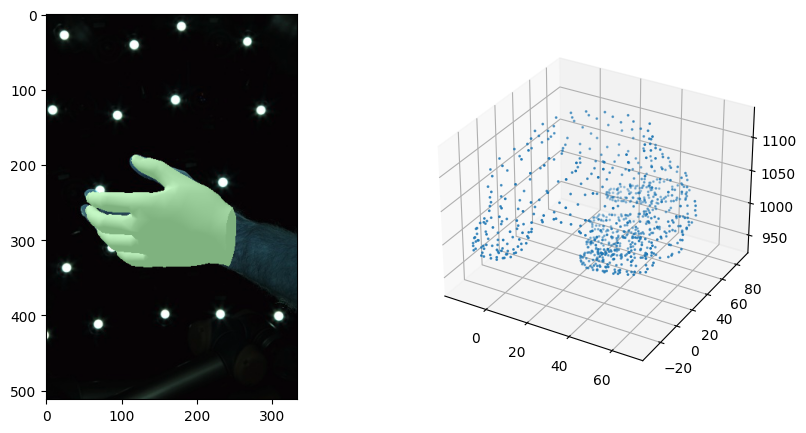

In [17]:
import os
import numpy as np
import cv2
import json
from glob import glob
import os.path as osp
os.environ["PYOPENGL_PLATFORM"] = "egl"
import smplx
import torch
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
PointLights,
DirectionalLights,
PerspectiveCameras,
Materials,
SoftPhongShader,
RasterizationSettings,
MeshRenderer,
MeshRendererWithFragments,
MeshRasterizer,
TexturesVertex)
from pytorch3d.transforms.so3 import so3_exponential_map, so3_log_map
import matplotlib.pyplot as plt

def save_obj(v, f, file_name='output.obj'):
    obj_file = open(file_name, 'w')
    for i in range(len(v)):
        obj_file.write('v ' + str(v[i][0]) + ' ' + str(v[i][1]) + ' ' + str(v[i][2]) + '\n')
    for i in range(len(f)):
        obj_file.write('f ' + str(f[i][0]+1) + '/' + str(f[i][0]+1) + ' ' + str(f[i][1]+1) + '/' + str(f[i][1]+1) + ' ' + str(f[i][2]+1) + '/' + str(f[i][2]+1) + '\n')
    obj_file.close()

def render_mesh(mesh, face, cam_param, render_shape, hand_type, R, T):
    batch_size, vertex_num = mesh.shape[:2]
    mesh = mesh / 1000 # milimeter to meter

    textures = TexturesVertex(verts_features=torch.ones((batch_size,vertex_num,3)).float().cuda())


    mesh = torch.stack((-mesh[:,:,0], -mesh[:,:,1], mesh[:,:,2]),2) # reverse x- and y-axis following PyTorch3D axis direction

    print('mesh', mesh.shape, mesh)


    mesh = Meshes(mesh, face, textures)

    cameras = PerspectiveCameras(
                                R=R,
                                T=T,
                                focal_length=cam_param['focal'],
                                principal_point=cam_param['princpt'],
                                device='cuda',
                                in_ndc=False,
                                image_size=torch.LongTensor(render_shape).cuda().view(1,2))

    print(cameras.get_camera_center())

    raster_settings = RasterizationSettings(image_size=render_shape, blur_radius=0.0, faces_per_pixel=1, perspective_correct=True)
    rasterizer = MeshRasterizer(cameras=cameras, raster_settings=raster_settings).cuda()
    lights = PointLights(device='cuda')
    shader = SoftPhongShader(device='cuda', cameras=cameras, lights=lights)
    if hand_type == 'right':
        color = ((1.0, 0.0, 0.0),)
    else:
        color = ((0.0, 1.0, 0.0),)
    materials = Materials(
	device='cuda',
        specular_color=color,
	shininess=0
    )

    # render
    with torch.no_grad():
        renderer = MeshRendererWithFragments(rasterizer=rasterizer, shader=shader)
        images, fragments = renderer(mesh, materials=materials)
        images = images[:,:,:,:3] * 255
        depthmaps = fragments.zbuf

    return images, depthmaps

# mano layer
smplx_path = '/home/azhuavlev/Desktop/Data/models/mano/MANO_LEFT.pkl'

# smplx.left_hand_mean



mano_layer = {'right': smplx.create(smplx_path, 'mano', use_pca=False, is_rhand=False, flat_hand_mean=False), 'left': smplx.MANO(smplx_path, use_pca=False, is_rhand=False, flat_hand_mean=False)}

# fix MANO shapedirs of the left hand bug (https://github.com/vchoutas/smplx/issues/48)
if torch.sum(torch.abs(mano_layer['left'].shapedirs[:,0,:] - mano_layer['right'].shapedirs[:,0,:])) < 1:
    print('Fix shapedirs bug of MANO')
    mano_layer['left'].shapedirs[:,0,:] *= -1

root_path = '/home/azhuavlev/Desktop/Data/InterHand/'
img_root_path = osp.join(root_path, 'images')
annot_root_path = osp.join(root_path, 'annotations')
split = 'test'
capture_idx = '0'
seq_name = 'ROM04_LT_Occlusion'
cam_idx = '400262'

save_path = osp.join(split, capture_idx, seq_name, cam_idx)
os.makedirs(save_path, exist_ok=True)

# with open(osp.join(annot_root_path, split, 'InterHand2.6M_' + split + '_MANO_NeuralAnnot.json')) as f:
#     mano_params = json.load(f)
# with open(osp.join(annot_root_path, split, 'InterHand2.6M_' + split + '_camera.json')) as f:
#     cam_params = json.load(f)
# with open(osp.join(annot_root_path, split, 'InterHand2.6M_' + split + '_joint_3d.json')) as f:
#     joints = json.load(f)
#
# img_path_list = glob(osp.join(img_root_path, split, 'Capture' + capture_idx, seq_name, 'cam' + cam_idx, '*.jpg'))

# img_path_list = ['/home/azhuavlev/Desktop/Data/InterHand_Neuman/03/images/00000.png']

# count number of files in /home/azhuavlev/Desktop/Data/InterHand_Neuman/03/images/
n_files = len([f for f in os.listdir('/home/azhuavlev/Desktop/Data/InterHand_Neuman/03/images/') if os.path.isfile(os.path.join('/home/azhuavlev/Desktop/Data/InterHand_Neuman/03/images/', f))])

for index in range(n_files):
    img_path = f'/home/azhuavlev/Desktop/Data/InterHand_Neuman/03/images/{index:05d}.png'
    frame_idx = img_path.split('/')[-1][5:-4]
    img = cv2.imread(img_path)
    img_height, img_width, _ = img.shape

    prev_render_depth = None
    for hand_type in ('right', 'left'):
        # get mesh coordinate
        try:
            # mano_param = mano_params[capture_idx][frame_idx][hand_type]
            # print('got', hand_type)
            # read this '/home/azhuavlev/Desktop/Data/InterHand_Neuman/03/cameras/00000.json'
            with open(f'/home/azhuavlev/Desktop/Data/InterHand_Neuman/03/cameras/{index:05d}.json') as f:
                cam_param = json.load(f)

            # read this '/home/azhuavlev/Desktop/Data/InterHand_Neuman/03/mano/00000.json'
            with open(f'/home/azhuavlev/Desktop/Data/InterHand_Neuman/03/mano/{index:05d}.json') as f:
                mano_param = json.load(f)[hand_type]
                print('mano_param', mano_param)

            if mano_param is None:
                print('No annotation for frame', hand_type)
                continue
        except KeyError:
            print('No annotation for frame', hand_type)
            continue

        # get MANO 3D mesh coordinates (world coordinate)
        mano_pose = torch.tensor(mano_param['pose']).view(-1,3)
        root_pose = mano_pose[0].view(1,3)
        hand_pose = mano_pose[1:,:].view(1,-1)
        shape = torch.tensor(mano_param['shape']).view(1,-1)
        trans = torch.tensor(mano_param['trans']).view(1,3)

        print('root_pose', root_pose)
        print('hand_pose', hand_pose)
        print('shape', shape)
        print('trans', trans)


        output = mano_layer[hand_type](global_orient=root_pose, hand_pose=hand_pose, betas=shape, transl=trans)
        print('mano_vertices', output.vertices[0])

        mesh = output.vertices[0].numpy() * 1000 # meter to milimeter


        orig_hand = mesh.copy()

        # apply camera extrinsics
        t, R = np.array(cam_param['campos'], dtype=np.float32).reshape(3), np.array(cam_param['camrot'], dtype=np.float32).reshape(3,3)
        t = -np.dot(R,t.reshape(3,1)).reshape(3) # -Rt -> t

        t = t/1000.0 # milimeter to meter

        # print('t', t.shape, t)
        # print('R', R.shape, R)
        # print('mesh', mesh.shape, mesh)
        #
        # print('mesh.transpose(1,0)', mesh.transpose(1,0).shape, mesh.transpose(1,0))
        # print('np.dot(R, mesh.transpose(1,0)).transpose(1,0)', np.dot(R, mesh.transpose(1,0)).transpose(1,0).shape, np.dot(R, mesh.transpose(1,0)).transpose(1,0))
        # print('t.reshape(1,3)', t.reshape(1,3).shape, t.reshape(1,3))

        R = torch.tensor(R).unsqueeze(0)

        # print('R', R.shape, R)

        rot_vec = so3_log_map(R)
        # print('rot_vec', rot_vec.shape, rot_vec)
        rot_vec_adj = rot_vec.clone()
        rot_vec_adj[:, :2] *= -1


        R = so3_exponential_map(rot_vec_adj)
        # print('R_adj', R.shape, R)

        R = R.squeeze(0).numpy()


        R_pytorch3d = R.copy().transpose(1, 0)
        T_pytorch3d = t.copy()
        # R_pytorch3d[:, :2] *= -1
        T_pytorch3d[:2] *= -1

        R_pytorch3d = torch.tensor(R_pytorch3d).unsqueeze(0)
        T_pytorch3d = torch.tensor(T_pytorch3d).unsqueeze(0)


        # mesh = np.dot(R, mesh.transpose(1,0)).transpose(1,0) + t.reshape(1,3)

        # save mesh to obj files
        save_obj(mesh, mano_layer[hand_type].faces, osp.join(save_path, img_path.split('/')[-1][:-4] + '_' + hand_type + '.obj'))

        # render
        mesh = torch.from_numpy(mesh).float().cuda()[None,:,:]
        face = torch.from_numpy(mano_layer[hand_type].faces.astype(np.int32)).cuda()[None,:,:]
        focal = torch.FloatTensor(cam_param['focal']).cuda()[None,:]
        princpt = torch.FloatTensor(cam_param['princpt']).cuda()[None,:]
        with torch.no_grad():
            render_rgb, render_depth = render_mesh(mesh, face, {'focal': focal, 'princpt': princpt}, (img_height,img_width), hand_type, R=R_pytorch3d, T=T_pytorch3d)

        # blend
        render_rgb = render_rgb[0].cpu().numpy()
        render_depth = render_depth[0].cpu().numpy()
        valid_mask = render_depth > 0
        if prev_render_depth is None:
            render_mask = valid_mask
            render_out = render_rgb * render_mask + img * (1 - render_mask)
            prev_render_depth = render_depth
        else:
            render_mask = valid_mask * np.logical_or(render_depth < prev_render_depth, prev_render_depth<=0)
            render_out = render_rgb * render_mask + render_out * (1 - render_mask)
            prev_render_depth = render_depth * render_mask + prev_render_depth * (1 - render_mask)


    %matplotlib inline
    # save image
    #cv2.imwrite(osp.join(save_path, img_path.split('/')[-1]), render_out)
    # plot render_out on one subplot, and mesh as 3d plot on the other subplot
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(121)
    ax.imshow(render_out.astype(np.uint8))
    ax = fig.add_subplot(122, projection='3d')
    mesh = orig_hand
    ax.scatter(mesh[:,0], mesh[:,1], mesh[:,2], s=1)
    plt.show()

    break

    # import matplotlib.pyplot as plt
    # plt.imshow(render_out.astype(np.uint8))
    # plt.show()


In [ ]:
import os
import numpy as np
import cv2
import json
from glob import glob
import os.path as osp
os.environ["PYOPENGL_PLATFORM"] = "egl"
import smplx
import torch
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
PointLights,
DirectionalLights,
PerspectiveCameras,
Materials,
SoftPhongShader,
RasterizationSettings,
MeshRenderer,
MeshRendererWithFragments,
MeshRasterizer,
TexturesVertex)
from pytorch3d.transforms.so3 import so3_exponential_map, so3_log_map

def save_obj(v, f, file_name='output.obj'):
    obj_file = open(file_name, 'w')
    for i in range(len(v)):
        obj_file.write('v ' + str(v[i][0]) + ' ' + str(v[i][1]) + ' ' + str(v[i][2]) + '\n')
    for i in range(len(f)):
        obj_file.write('f ' + str(f[i][0]+1) + '/' + str(f[i][0]+1) + ' ' + str(f[i][1]+1) + '/' + str(f[i][1]+1) + ' ' + str(f[i][2]+1) + '/' + str(f[i][2]+1) + '\n')
    obj_file.close()

def render_mesh(mesh, face, cam_param, render_shape, hand_type, R, T):
    batch_size, vertex_num = mesh.shape[:2]
    mesh = mesh# / 1000 # milimeter to meter

    textures = TexturesVertex(verts_features=torch.ones((batch_size,vertex_num,3)).float().cuda())
    mesh = torch.stack((-mesh[:,:,0], -mesh[:,:,1], mesh[:,:,2]),2) # reverse x- and y-axis following PyTorch3D axis direction
    mesh = Meshes(mesh, face, textures)

    cameras = PerspectiveCameras(
                                R=R,
                                T=T,
                                focal_length=cam_param['focal'],
                                principal_point=cam_param['princpt'],
                                device='cuda',
                                in_ndc=False,
                                image_size=torch.LongTensor(render_shape).cuda().view(1,2))

    print(cameras.get_camera_center())

    raster_settings = RasterizationSettings(image_size=render_shape, blur_radius=0.0, faces_per_pixel=1, perspective_correct=True)
    rasterizer = MeshRasterizer(cameras=cameras, raster_settings=raster_settings).cuda()
    lights = PointLights(device='cuda')
    shader = SoftPhongShader(device='cuda', cameras=cameras, lights=lights)
    if hand_type == 'right':
        color = ((1.0, 0.0, 0.0),)
    else:
        color = ((0.0, 1.0, 0.0),)
    materials = Materials(
	device='cuda',
        specular_color=color,
	shininess=0
    )

    # render
    with torch.no_grad():
        renderer = MeshRendererWithFragments(rasterizer=rasterizer, shader=shader)
        images, fragments = renderer(mesh, materials=materials)
        images = images[:,:,:,:3] * 255
        depthmaps = fragments.zbuf

    return images, depthmaps

# mano layer
smplx_path = '/home/azhuavlev/Desktop/Data/models/mano/MANO_LEFT.pkl'

# smplx.left_hand_mean



mano_layer = {'right': smplx.create(smplx_path, 'mano', use_pca=False, is_rhand=False, flat_hand_mean=False), 'left': smplx.MANO(smplx_path, use_pca=False, is_rhand=True, flat_hand_mean=False)}

# fix MANO shapedirs of the left hand bug (https://github.com/vchoutas/smplx/issues/48)
if torch.sum(torch.abs(mano_layer['left'].shapedirs[:,0,:] - mano_layer['right'].shapedirs[:,0,:])) < 1:
    print('Fix shapedirs bug of MANO')
    mano_layer['left'].shapedirs[:,0,:] *= -1

root_path = '/home/azhuavlev/Desktop/Data/InterHand/'
img_root_path = osp.join(root_path, 'images')
annot_root_path = osp.join(root_path, 'annotations')
split = 'test'
capture_idx = '0'
seq_name = 'ROM04_LT_Occlusion'
cam_idx = '400262'

save_path = osp.join(split, capture_idx, seq_name, cam_idx)
os.makedirs(save_path, exist_ok=True)

# with open(osp.join(annot_root_path, split, 'InterHand2.6M_' + split + '_MANO_NeuralAnnot.json')) as f:
#     mano_params = json.load(f)
# with open(osp.join(annot_root_path, split, 'InterHand2.6M_' + split + '_camera.json')) as f:
#     cam_params = json.load(f)
# with open(osp.join(annot_root_path, split, 'InterHand2.6M_' + split + '_joint_3d.json')) as f:
#     joints = json.load(f)
#
# img_path_list = glob(osp.join(img_root_path, split, 'Capture' + capture_idx, seq_name, 'cam' + cam_idx, '*.jpg'))

# img_path_list = ['/home/azhuavlev/Desktop/Data/InterHand_Neuman/03/images/00000.png']

# count number of files in /home/azhuavlev/Desktop/Data/InterHand_Neuman/03/images/
n_files = len([f for f in os.listdir('/home/azhuavlev/Desktop/Data/InterHand_Neuman/03/images/') if os.path.isfile(os.path.join('/home/azhuavlev/Desktop/Data/InterHand_Neuman/03/images/', f))])

for index in range(n_files):
    img_path = f'/home/azhuavlev/Desktop/Data/InterHand_Neuman/03/images/{index:05d}.png'
    frame_idx = img_path.split('/')[-1][5:-4]
    img = cv2.imread(img_path)
    img_height, img_width, _ = img.shape

    prev_render_depth = None
    for hand_type in ('right', 'left'):
        # get mesh coordinate
        try:
            # mano_param = mano_params[capture_idx][frame_idx][hand_type]
            # print('got', hand_type)
            # read this '/home/azhuavlev/Desktop/Data/InterHand_Neuman/03/cameras/00000.json'
            with open(f'/home/azhuavlev/Desktop/Data/InterHand_Neuman/03/cameras/{index:05d}.json') as f:
                cam_param = json.load(f)

            # read this '/home/azhuavlev/Desktop/Data/InterHand_Neuman/03/mano/00000.json'
            with open(f'/home/azhuavlev/Desktop/Data/InterHand_Neuman/03/mano/{index:05d}.json') as f:
                mano_param = json.load(f)[hand_type]


            if mano_param is None:
                print('No annotation for frame', hand_type)
                continue
        except KeyError:
            print('No annotation for frame', hand_type)
            continue

        # get MANO 3D mesh coordinates (world coordinate)
        mano_pose = torch.tensor(mano_param['pose']).view(-1,3)
        root_pose = mano_pose[0].view(1,3)
        hand_pose = mano_pose[1:,:].view(1,-1)
        shape = torch.tensor(mano_param['shape']).view(1,-1)
        trans = torch.tensor(mano_param['trans']).view(1,3)
        output = mano_layer[hand_type](global_orient=root_pose, hand_pose=hand_pose, betas=shape, transl=trans)
        mesh = output.vertices[0].numpy() * 1000 # meter to milimeter

        orig_hand = mesh.copy()

        # apply camera extrinsics
        cam_param = cam_params[capture_idx]
        t, R = np.array(cam_param['campos'][str(cam_idx)], dtype=np.float32).reshape(3), np.array(cam_param['camrot'][str(cam_idx)], dtype=np.float32).reshape(3,3)
        t = -np.dot(R,t.reshape(3,1)).reshape(3) # -Rt -> t

        # print('t', t.shape, t)
        # print('R', R.shape, R)
        # print('mesh', mesh.shape, mesh)
        #
        # print('mesh.transpose(1,0)', mesh.transpose(1,0).shape, mesh.transpose(1,0))
        # print('np.dot(R, mesh.transpose(1,0)).transpose(1,0)', np.dot(R, mesh.transpose(1,0)).transpose(1,0).shape, np.dot(R, mesh.transpose(1,0)).transpose(1,0))
        # print('t.reshape(1,3)', t.reshape(1,3).shape, t.reshape(1,3))

        R = torch.tensor(R).unsqueeze(0)

        # print('R', R.shape, R)

        rot_vec = so3_log_map(R)
        # print('rot_vec', rot_vec.shape, rot_vec)
        rot_vec_adj = rot_vec.clone()
        rot_vec_adj[:, :2] *= -1


        R = so3_exponential_map(rot_vec_adj)
        # print('R_adj', R.shape, R)

        R = R.squeeze(0).numpy()


        R_pytorch3d = R.copy().transpose(1, 0)
        T_pytorch3d = t.copy()
        # R_pytorch3d[:, :2] *= -1
        T_pytorch3d[:2] *= -1

        R_pytorch3d = torch.tensor(R_pytorch3d).unsqueeze(0)
        T_pytorch3d = torch.tensor(T_pytorch3d).unsqueeze(0)


        # mesh = np.dot(R, mesh.transpose(1,0)).transpose(1,0) + t.reshape(1,3)

        # save mesh to obj files
        save_obj(mesh, mano_layer[hand_type].faces, osp.join(save_path, img_path.split('/')[-1][:-4] + '_' + hand_type + '.obj'))

        # render
        mesh = torch.from_numpy(mesh).float().cuda()[None,:,:]
        face = torch.from_numpy(mano_layer[hand_type].faces.astype(np.int32)).cuda()[None,:,:]
        focal = torch.FloatTensor(cam_param['focal'][str(cam_idx)]).cuda()[None,:]
        princpt = torch.FloatTensor(cam_param['princpt'][str(cam_idx)]).cuda()[None,:]
        with torch.no_grad():
            render_rgb, render_depth = render_mesh(mesh, face, {'focal': focal, 'princpt': princpt}, (img_height,img_width), hand_type, R=R_pytorch3d, T=T_pytorch3d)

        # blend
        render_rgb = render_rgb[0].cpu().numpy()
        render_depth = render_depth[0].cpu().numpy()
        valid_mask = render_depth > 0
        if prev_render_depth is None:
            render_mask = valid_mask
            render_out = render_rgb * render_mask + img * (1 - render_mask)
            prev_render_depth = render_depth
        else:
            render_mask = valid_mask * np.logical_or(render_depth < prev_render_depth, prev_render_depth<=0)
            render_out = render_rgb * render_mask + render_out * (1 - render_mask)
            prev_render_depth = render_depth * render_mask + prev_render_depth * (1 - render_mask)


    %matplotlib inline
    # save image
    #cv2.imwrite(osp.join(save_path, img_path.split('/')[-1]), render_out)
    # plot render_out on one subplot, and mesh as 3d plot on the other subplot
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(121)
    ax.imshow(render_out.astype(np.uint8))
    ax = fig.add_subplot(122, projection='3d')
    mesh = orig_hand
    ax.scatter(mesh[:,0], mesh[:,1], mesh[:,2], s=1)
    plt.show()

    # import matplotlib.pyplot as plt
    # plt.imshow(render_out.astype(np.uint8))
    # plt.show()
